# PyLIMA Example

In this notebook we look at how we can import and use models from the [pyLIMA package](https://github.com/ebachelet/pyLIMA), a package for simulating and analyzing gravitational lensing effects.  

Note that the pyLima package is not installed as part of the default LightCurveLynx installation. Users will need to manually install them via pip (e.g. `pip install pyLIMA`) in order to run this notebook.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.math_nodes.ra_dec_sampler import ObsTableRADECSampler
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.pylima_models import PyLIMAWrapperModel
from lightcurvelynx.utils.plotting import plot_lightcurves

## Create the Survey Data

There are two types of data files we need to run a LightCurveLynx simulation an `ObsTable` and passband information. In most cases we will want to load the simulated or actual observation tables from various surveys.

In this example we will use the default Rubin passbands. But we will create a fake observation cadence that is better for visualizing microlensing events. Specifically, we will take make two fake `OpSim` that observes the exact same location on the sky (45.0, -20.0) three times a night, once in each of the 'r", "g", and 'i' bands.

In [18]:
filters = ["g", "r", "i"]
passband_group = PassbandGroup.from_preset(preset="LSST", filters=filters)

num_days = 100
num_samples = 3 * num_days
survey_data = {
    "observationStartMJD": np.linspace(60676.0, 60676.0 + num_days, num_samples),
    "fieldRA": np.full(num_samples, 45.0),
    "fieldDec": np.full(num_samples, -20.0),
    "zp_nJy": np.random.normal(loc=1.0, scale=0.1, size=num_samples),
    "filter": [filters[i % 3] for i in range(num_samples)],
    "seeing": np.random.normal(loc=1.1, scale=0.1, size=num_samples),
    "skybrightness": np.random.normal(loc=20.0, scale=0.1, size=num_samples),
    "exptime": np.full(num_samples, 30.0),
    "nexposure": np.full(num_samples, 2),
}
obs_table = OpSim(survey_data)

## Create the model

Next we want to create a model of the physical phenomena that we would like to simulation (in this case pyLIMA microlensing models). There are a variety of settable parameters we can set for these models depending on the type of models.

Let's set the time and positions parameters based on the survey:

* RA drawn uniformly from [44.0, 46.0]
* DEC drawn uniformly from [-19.0, -21.0]
* T0 drawn uniformly from the time range of our survey [60676.0, 60776.0]

Since the field of view of a Rubin observation has a radius of 1.75 degrees, we can sample RA and DEC for our observations from a small region around the center of the image and know they will show up in all the images.

In [19]:
ra_sampler = NumpyRandomFunc("uniform", low=44.0, high=46.0)
dec_sampler = NumpyRandomFunc("uniform", low=-21.0, high=-19.0)
t0_sampler = NumpyRandomFunc("uniform", low=60676.0, high=60776.0)

In addition to those parameters, PyLIMA models come with a large number of their own settable parameters that vary with the simulation options. For concreteness, lets use a PSPL model with the following settings:

- Full Parallax
- Flux blending type of "gblend" 
- No double source
- No orbital motion

Given those options the required parameters include:

- Already specified parameters (`t0`)
- New model specific parameters (`u0`, `tE`, `piEN`, `piEE`)
- Source flux values for each filter (`fsource_r`, `fsource_g`, …). These are specified to the model as magnitudes.
- Blend flux values for each filter (`gblend_r`, `gblend_g`, …). The names of these can vary depending on the blending used.

In [20]:
# Use a fixed u0 and random values for tE, piEN, and piEE
pylima_params = {
    "u0": 0.1,
    "tE": NumpyRandomFunc("uniform", low=10.0, high=30.0),
    "piEN": NumpyRandomFunc("uniform", low=0.0, high=0.5),
    "piEE": NumpyRandomFunc("uniform", low=0.0, high=0.5),
}

# Both the source and blend amounts are specified as magnitudes in each filter.
source_mags = {
    "g": 22.0 + np.random.normal(scale=0.3),
    "r": 21.5 + np.random.normal(scale=0.3),
    "i": 21.2 + np.random.normal(scale=0.3),
}
blend_mags = {
    "g": 23.5 + np.random.normal(scale=0.3),
    "r": 23.0 + np.random.normal(scale=0.3),
    "i": 22.8 + np.random.normal(scale=0.3),
}

We can now create the actual model object.

In [21]:
source = PyLIMAWrapperModel(
    "PSPL",  # Model type
    source_mags=source_mags,
    blend_mags=blend_mags,
    ra=ra_sampler,
    dec=dec_sampler,
    t0=t0_sampler,
    parallax_model="Full",
    blend_flux_parameter="gblend",
    pylima_params=pylima_params,
    node_label="pylima_microlens_model",
)

Parallax(Full) estimated for the telescope r: SUCCESS


Almost all of the parameters are randomly sampled. Let's look at a sampling.

In [22]:
sampled_state = source.sample_parameters(num_samples=1)

for key, val in sampled_state["pylima_microlens_model"].items():
    print(f"{key}: {val}")

ra: 45.400361296259334
dec: -19.3970332731108
redshift: None
t0: 60699.610879427884
distance: None
fsource_g: 11328.005854146435
fsource_r: 6893.867830658217
fsource_i: 12860.441489823901
gblend_g: 1813.0762080947236
gblend_r: 2924.5263690220777
gblend_i: 2707.7107104829884
u0: 0.1
tE: 15.074271274049785
piEN: 0.2690150446138724
piEE: 0.3028761102958824


If we sample again, we get different values.

In [23]:
sampled_state = source.sample_parameters(num_samples=1)

for key, val in sampled_state["pylima_microlens_model"].items():
    print(f"{key}: {val}")

ra: 44.85061671453245
dec: -19.161198641350023
redshift: None
t0: 60715.89031236521
distance: None
fsource_g: 11328.005854146435
fsource_r: 6893.867830658217
fsource_i: 12860.441489823901
gblend_g: 1813.0762080947236
gblend_r: 2924.5263690220777
gblend_i: 2707.7107104829884
u0: 0.1
tE: 28.29928597242462
piEN: 0.10042729793757565
piEE: 0.1780664622230586


## Generate the simulations

We can now generate random simulations with all the information defined above. The `simulate_lightcurves` function takes four parameters: the source from which we want to sample (here the collection of lightcurves), the number of results to simulate (100), the opsim, and the passband information.

We use the `time_window_offset` parameter to limit the samples for each object to 10 days before and 50 days after that object's `t0`. These bounds are provided in the observer frame.

In [24]:
lightcurves = simulate_lightcurves(
    source,
    100,
    obs_table,
    passband_group,
)

Simulating:   0%|          | 0/100 [00:00<?, ?obj/s]/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvel

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for

/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 100 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "epv00" yielded 100 of "warning: date outsidethe range 1900-2100 AD"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 100 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jkubica/envs/lightcurvelynx/lib/python3.13/site-packages/erfa/core.py:133: E

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for

The results are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. Each row corresponds to a single simulated object, with a unique id, ra, dec, etc. The column `params` include all internal state, including hyperparameter settings, that was used to generate this object. The nested `lightcurve` column contains the times, filters, and fluxes for each observation of that object.  We can treat it as a (nested) table.

Let's look at the lightcurve for the first object sampled:

In [25]:
print(lightcurves.loc[0]["lightcurve"])

              mjd filter          flux       fluxerr  flux_perfect  \
0    60676.000000      g  1.905461e+06  1.864570e+07  2.054987e+07   
1    60676.334448      r  1.737801e+06  1.843117e+07  2.016819e+07   
..            ...    ...           ...           ...           ...   
298  60775.665552      r  1.737801e+06  1.843094e+07  2.016819e+07   
299  60776.000000      i  1.737801e+06  3.309781e+07  3.483522e+07   

     survey_idx  obs_idx  is_saturated  
0             0        0          True  
1             0        1          True  
..          ...      ...           ...  
298           0      298          True  
299           0      299          True  

[300 rows x 8 columns]


Now let's plot the first few lightcurves to see what they look like when observed via Rubin's cadence.

In [26]:
for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    if lc["nobs"] == 0:
        continue

    # Unpack the nested columns (filters, mjd, flux, and flux error).
    lc_filters = np.asarray(lc["lightcurve"]["filter"], dtype=str)
    lc_mjd = np.asarray(lc["lightcurve"]["mjd"], dtype=float)
    lc_flux = np.asarray(lc["lightcurve"]["flux"], dtype=float)
    lc_fluxerr = np.asarray(lc["lightcurve"]["fluxerr"], dtype=float)

    # Get information about the sampled parameter values for the plot's title.
    t0 = lc["params"]["source.t0"]
    mej = lc["params"]["source.mej"]
    redshift = lc["params"]["source.redshift"]

    zoom_inds = (lc_mjd > t0 - 500) & (lc_mjd < t0 + 2000)

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=lc_flux[zoom_inds],
        times=lc_mjd[zoom_inds],
        fluxerrs=lc_fluxerr[zoom_inds],
        filters=lc_filters[zoom_inds],
        title=f"Sample {idx} from with t0={t0:.2f}, mej={mej:.2f}, redshift={redshift:.2f}",
    )
    ax.plot([t0, t0], ax.get_ylim(), "k-", label="t0")
    ax.legend()
    plt.show()

KeyError: 'source.t0'

## Zooming In

As you can see from the plots above, the combination of a random sampling scheme for `t0` combined with the Rubin OpSim, might mean that we miss the kilanova event in the data. While this is exactly the type of behavior we want to be able to characterize for analyzing the survey's selection function, we might want to see what the event looks like under ideal conditions.

Let's zoom in, by creating a fixed kilanova object and a custom observing strategy. We will use `evaluate_bandfluxes` to compute the noise free bandfluxes at a set of times (instead of matching the times with the observation table).

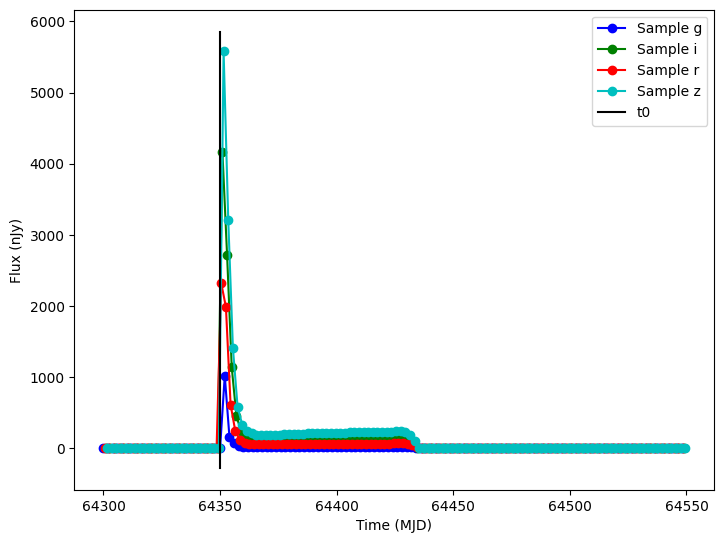

In [ ]:
# Set fixed parameters for this redback model.
t0 = 64350.0
parameters = {
    "mej": 0.05,
    "redshift": 0.05,
    "temperature_floor": 3000,
    "kappa": 1,
    "vej": 0.2,
}
source = RedbackWrapperModel(
    rb_model,
    parameters=parameters,  # Set ALL the redback model parameters
    ra=0.0,  # Set other parameters
    dec=-10.0,
    t0=t0,
    node_label="source",
)
state = source.sample_parameters(num_samples=1)

# Simulate from 50 data before t0 to 200 days after.
obs_times = np.arange(t0 - 50, t0 + 200, 0.5)
obs_filters = [filters[i % 4] for i in range(len(obs_times))]
bandfluxes_perfect = source.evaluate_bandfluxes(passband_group, obs_times, obs_filters, state)

# Plot the lightcurves.
ax = plot_lightcurves(
    fluxes=bandfluxes_perfect,
    times=obs_times,
    fluxerrs=None,
    filters=obs_filters,
)
ax.plot([t0, t0], ax.get_ylim(), "k-", label="t0")
ax.legend()
plt.show()

## Using Redback Priors

Redback models have the ability to draw their parameters using samples from the `bilby` package. We can either define these priors manually or use one of the many sets of priors that are predefined in the redback package ([more information on redback priors here](https://redback.readthedocs.io/en/latest/priors.html)). Now let’s load the predefined priors for the "one_component_kilonova_model".

We can see which parameters are included by printing the list.

In [ ]:
priors = get_priors(model="one_component_kilonova_model")
print("Priors: ", priors.keys())

Priors:  dict_keys(['redshift', 'mej', 'vej', 'kappa', 'temperature_floor'])


We can incorporate the priors into the model with a variety of mechanisms. The simplest is to pass them as a `priors` parameter when creating the wrapper node.

In [ ]:
source2 = RedbackWrapperModel(
    rb_model,
    priors=priors,
    ra=ra_dec_sampler.ra,  # Set other parameters
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
)
lightcurves = simulate_lightcurves(source2, 1, opsim_db, passband_group)

Note the difference between `parameters` and the `priors` argument is how the data is interpreted. The `parameters` argument is a dictionary mapping each parameter name to a LightCurveLynx setter. The `priors` argument assumes a Bilby `PriorDict`.

Users can use a combination of the two methods by passing both a `parameters` and a `priors` argument. If the same parameter is defined in both sources, the `parameters` (LightCurveLynx) value will take precedence.

For example, we could override the sampler for redshift as:

In [ ]:
parameters = {
    "redshift": NumpyRandomFunc("uniform", low=0.0, high=0.1),  # This is used
}

source3 = RedbackWrapperModel(
    rb_model,
    priors=priors,  # All values except redshift are used
    parameters=parameters,  # Overrides redshift
    ra=ra_dec_sampler.ra,  # Set other parameters
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
)

If we generate a single sample from `source3` and look at the etire graph state, we see that the redshift parameters come from the numpy node instead of the bilby prior.

In [ ]:
print(source3.sample_parameters(num_samples=1))

ra_dec_sampler:
    ra: [12.1881145]
    dec: [-43.97749671]
    time: 62051.02200133613
source:
    ra: [12.1881145]
    dec: [-43.97749671]
    redshift: 0.0641569436029381
    t0: 64156.61862285716
    distance: None
    mej: 0.03629812525749713
    vej: 0.48535636093747747
    kappa: 10.81544950576049
    temperature_floor: 295.3331328541103
NumpyRandomFunc:uniform_2:
    low: 0.0
    high: 0.1
    function_node_result: 0.0641569436029381
time_sampler:
    low: 60796.00143922635
    high: 64448.429406568604
    function_node_result: 64156.61862285716
BilbyPriorNode:_non_func_4:
    redshift: 0.027076298480240905
    mej: 0.03629812525749713
    vej: 0.48535636093747747
    kappa: 10.81544950576049
    temperature_floor: 295.3331328541103
